![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

In [3]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [4]:
# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [6]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [7]:
# Definición de la función que calcula el gini index

def gini(y):
    
    """
    Función que calcula el gini index para conjunto de datos 
    
    PARAMETERS  
        y [DataFrame]: que contiene la variable objetivo
    RETURN
        gini_index [float]: Valor del gini index calculado
    """
    # Si no se tienen observaciones, la ganancia es 0
    if y.shape[0] == 0:
        return 0
    # De lo contrario, se calcula
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [8]:
# Cálculo de ganancia o impureza de la bifurcación

def gini_impurity(X_col, y, split):
    
    """
    Función para calcular la ganancia en la variable objetivo 'y' de la bifurcación resultante 
    de la división del a variable 'X_col' en el valor 'split'
    
    PARAMETERS
        X_col [int]  :  posición de la columna a la que se desea calcular el gini_index en un DataFrame X
        y [DataFrame]:  variable objetivo    
        split[float] :  valor a partir del cual se desea realizar la bifurcación ..
                        .. X_l = X[X<split],   X_r = X[X>=split]
    RETURN
        gini_impurity_: valor de la ganancia de la bifurcación evaluada.
    """
    
    # Se realiza la partición de acuerdo al valor de 'split'
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    # Se calcula el 'gini' para cada partición resultante
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    # Se calcula la ganancia a partir de la ponderación del gini en las particiones
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [9]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol

def best_split(X, y, num_pct=10):
   
    """
    Función para obtener cual es la mejor variable 'j' y su punto más óptimo de partición para realizar la bifurcación a partir
    de la ganancia 'gain'
    
    PARAMETERS
    X [DataFrame] : Arreglo que contiene las observaciones de cada variable predictora
    y [DataFrame] : Arreglo que contiene la variable respuesta para cada observación en X
    num_pct [int] : Número de percentiles a evaluar para realizar las bifurcaciones.
    
    RETURN
    list:   [   
                j: indice de la variable en X en la que se obtiene mayor ganancia al realizar el corte,
                split: valor en donde se obtiene la mayor ganancia al realizar el corte,
                gain; ganancia obtenida con dicho corte 
            ]
    """
    
    # Se obtienen las columnas del DataFrame X
    features = range(X.shape[1])
    
    # Se definen valores iniciales para la variable respuesta
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles en el DataFrame X
    for j in features:
        
        # Se obtienen los valores de las particiones de acuerdo al número de percentiles definidos
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            #Se calcula la ganancia obtenida al realizar dicho corte
            gain = gini_impurity(X.iloc[:, j], y, split)
            
            # Se busca la partición que genere la mayor ganancia.
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [10]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    """
    Función para desplegar el árbol hasta alcanzar los parámetros de Stop definidos
    
    PARAMETERS
    X [DataFrame]   : arreglo que contiene las observaciones de las variables predictoras
    y [DataFrame]   : arreglo que contiene la variable respuesta para cada observación
    level [int]     : profundidad inicial del árbol, default 0
    min_gain [float]: ganancia mínima esperada de una partición para continuar con el despliegue del árbol
    max_depth [int] : profunidad máxima del árbol
    num_pct [int]   : número de percentiles sobre los cuales se evaluará el punto de corte en cada partición
    
    RETURN
    
    [Dictionary]:   
        {
            y_pred: predicción de la rama del árbol
            y_prob: 
            level : nivel del árbol
            split : [j, split, gain]
            gain  : ganancia de cada nodo
            sl    : rama izquierda de cada nodo (dict)
            sr    : rama derecha de cada nodo   (dict)
            
        }                
        
    """
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

In [11]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [12]:
accuracy = []

#Se itera con 10 profundidades en el arbol para obtener el accuracy mas alto
for i in range(10):
        
    man_tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=i+1, num_pct=10)

    # Se obtienen las predicciones
    mt_pred = tree_predict(X_test, man_tree, proba = False)
    mt_pred

    # Se calcula el Accuracy del árbol construido
    mt_accur = sum(y_test == mt_pred)/y_test.shape[0]
    accuracy.append(mt_accur)

In [13]:
# Obtenemos la profundidad y el accuracy mas óptimo
accu = max(accuracy)
profu = accuracy.index(accu)

print ('El accuracy en el set de test es: ',round(accu,4))
print ('La profundidad optima con la que se obtuvo este accuracy fue: ',profu)


El accuracy en el set de test es:  0.888
La profundidad optima con la que se obtuvo este accuracy fue:  4


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [14]:
# Celda 2

def man_bagging(X_tr, Y_tr, X_ts, n_clas):
    
    """
    Función para generar un modelo de Bagging con 'n_clas' clasificadores, donde el ensamblaje se realiza
    a partir de votación mayoritaria
    
    PARAMETERS
    X_tr [DataFrame]: Conjunto de observaciones de variables predictoras para entrenamiento
    Y_tr [DataFrame]: Conjunto de observaciones de variables respuesta para entrenamiento
    X_ts [DataFrame]: Conjunto de observaciones de variables predictoras para test
    n_class [int]: número de clasificadores a ensamblar
    
    RETURN
    ens_predict [Series]: Predicciones después del Bagging y votación mayoritaria
    
    """
    
    n_samples = X_tr.shape[0] #Número de observaciones
    predicts = pd.DataFrame(index=X_ts.index, columns=[list(range(n_clas))]) #DF vacío para guardar las predicciones de cada árbol
    
    for i in range(0,n_clas):
        
        # Se realiza el muestreo aleatorio de observaciones
        samp_bag = np.random.choice(a=n_samples, size=n_samples, replace=True) #boostrap con repetición permitida
        
        X_it = X_tr.reset_index().drop(['index'], axis = 1).iloc[samp_bag,:] #Nueva muestra de entrenamiento
        Y_it = Y_tr.reset_index().drop(['index'], axis = 1).iloc[samp_bag,:]
        
        # Se entrena un arbol de decisión con dichas observaciones y se incluye a la lista 'tree_bag'
        tree_it = DecisionTreeClassifier().fit(X_it, Y_it)        
        
        # Se realizan las predicciones para X_test
        pred_it = tree_it.predict(X_ts)
        
        # Se guarda dentro del DataFrame en la columna correspondiente al iesimo predictor
        predicts.iloc[:,i] = pred_it
        
        # Predicción para cada observación de cada predictor
        # Se transpone para poder hacer operaciones de promedio en cada fila que representa las predicciones de cada arbol
        pred_tree = predicts.transpose()
     
        # Se realiza la votación mayoritaria y se asgina la predicción
        ens_predict = (pred_tree.mean()>=0.5).astype(int)
    
    return ens_predict
    

In [15]:
mb_pred = man_bagging(X_train, y_train, X_test, 10)
mb_pred

257343    0
326011    0
242354    1
266376    1
396954    1
         ..
144298    0
364521    1
120072    1
99878     0
387162    0
Length: 3464, dtype: int32

In [16]:
mb_accuracy =  sum(mb_pred == y_test)/y_test.shape[0]
mb_accuracy

0.8556581986143187

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [17]:
# Celda 3

BG_clsf = BaggingClassifier(
                            base_estimator = None,
                            n_estimators = 10,
                            max_features = int(np.log(X_train.shape[1]))
                            )
    
BG_clsf.fit(X_train, y_train)

BG_pred = BG_clsf.predict(X_test)

BG_accuracy = sum(BG_pred == y_test)/y_test.shape[0]

print(" El accuracy del modelo es: ")
print(BG_accuracy)

 El accuracy del modelo es: 
0.8620092378752887


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [18]:
# Celda 4

RF_clsf = RandomForestClassifier()
RF_clsf.fit(X_train, y_train)

RF_pred = RF_clsf.predict(X_test)
RF_accuracy = sum(y_test == RF_pred)/y_test.shape[0]
RF_accuracy

0.8441108545034642

#### Comentarios

El modelo RandomForest sin calibrar presenta un accuracy de 0.844. En general, es bastante aceptable, sin embargo, al compararlo con XGBoost, se ve que hay una diferencia entre el desempeño de ambos

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [19]:
# Celda 5
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

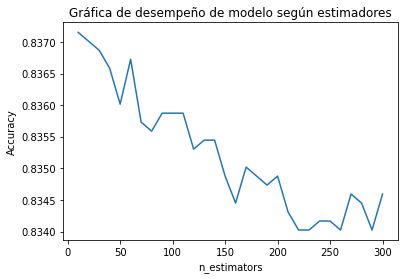

In [20]:
import matplotlib.pyplot as plt
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Gráfica de desempeño de modelo según estimadores')
plt.show()

In [21]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=25, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    

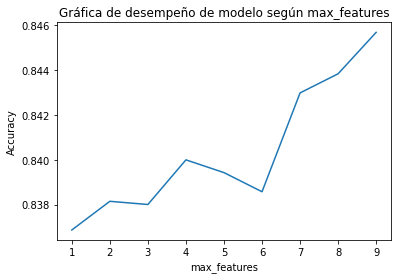

In [22]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Gráfica de desempeño de modelo según max_features')
plt.show()

In [23]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 15, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in depth_range:
    clf = RandomForestClassifier(n_estimators=25, random_state=1, n_jobs=-1, max_features=9 , max_depth = estimator )
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

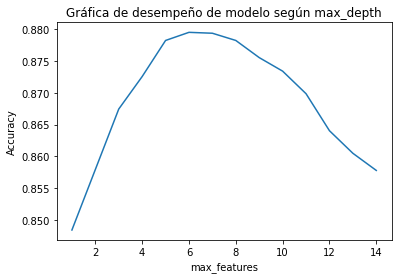

In [24]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Gráfica de desempeño de modelo según max_depth')
plt.show()

In [25]:
# Definición del modelo con los parámetros max_features=6 y n_estimators=200 
rf_best = RandomForestClassifier(n_estimators=25, max_features=9, random_state=1, n_jobs=-1, max_depth = 6)
rf_best.fit(X, y)
rf_best_accuracy = cross_val_score(rf_best, X, y, cv=5, scoring='accuracy').mean()
print("Mejor modelo calibrado - Parametros Accuracy: " , rf_best_accuracy )

Mejor modelo calibrado - Parametros Accuracy:  0.882229633158647


#### Comentarios

Con la calibración, el accuracy mejora considerablemente, pasando de 0.84 a 0.88. En general, si solamente se calibrara un hiperparámetro a la vez, la mejora no sería tan significativa como lo fue al calibrar los 3 hiperparámetros al mismo tiempo. El mejor modelo se obtuvo con los siguientes hiperparámetros:

* n_estimators = 25
* max_features = 9
* max_depth = 6

También se puede observar que el hiperparámetro que mayor influencia tiene en el desempeño es max_depth.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [26]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [38]:
# Celda 6

# Importación y definición de modelo XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
print(xgb)

accuracy_scores_ini = []

accuracy_scores_ini.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy').mean())

xgb_accuracy = accuracy_scores_ini[0]
print("\n\nAccuracy XGBoost: ", accuracy_scores_ini)



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


Accuracy XGBoost:  [0.8742719040440956]


Sin calibrar, XGBoost presenta resultados bastantes buenos, llegando a 0.87 de accuracy, que es mucho mejor al accuracy de Random Forest sin calibrar. Esto guarda relación con lo que se ha estudiado teóricamente.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [28]:
# Celda 7

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(0, 100, 5)
new_estimator_range =[]
for i in estimator_range:
    new_estimator_range.append(i/100) 
print(new_estimator_range)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in new_estimator_range:
    clf = XGBClassifier(learning_rate=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())


[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


Text(0.5, 1.0, 'Desempeño del modelo según learning rate')

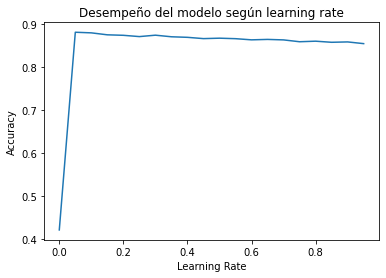

In [29]:
import matplotlib.pyplot as plt
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(new_estimator_range, accuracy_scores)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Desempeño del modelo según learning rate')

In [30]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(0, 100, 5)
new_estimator_range =[]
for i in estimator_range:
    new_estimator_range.append(i/100) 
print(new_estimator_range)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in new_estimator_range:
    clf = XGBClassifier(learning_rate=.05, random_state=1, n_jobs=-1, gamma =estimator)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


Text(0.5, 1.0, 'Desempeño del modelo según Gamma')

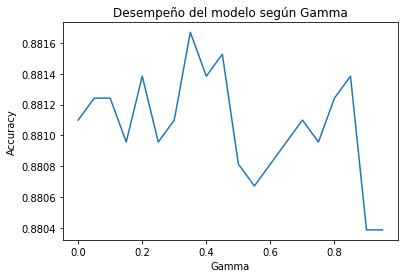

In [31]:
import matplotlib.pyplot as plt
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(new_estimator_range, accuracy_scores)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title('Desempeño del modelo según Gamma')

In [32]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
accuracy_scores = []
estimator_range = range(0, 100, 5)
new_estimator_range =[]
for i in estimator_range:
    new_estimator_range.append(i/100) 
print(new_estimator_range)


# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in new_estimator_range:
    clf = XGBClassifier(learning_rate=.05, random_state=1, n_jobs=-1, gamma =.35, colsample_bytree = estimator )
    print(estimator, "", cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
0.0  0.867019606296904
0.05  0.867019606296904
0.1  0.867019606296904
0.15  0.867019606296904
0.2  0.867019606296904
0.25  0.8746994553750248
0.3  0.8746994553750248
0.35  0.8805305923137817
0.4  0.8805305923137817
0.45  0.8813837740781967
0.5  0.8813837740781967
0.55  0.8813837740781967
0.6  0.881526223788596
0.65  0.881526223788596
0.7  0.8816679657999377
0.75  0.8816679657999377
0.8  0.8809571326460566
0.85  0.8809571326460566
0.9  0.8810992790568596
0.95  0.8810992790568596


Text(0.5, 1.0, 'Desempeño del modelo según colsample by tree')

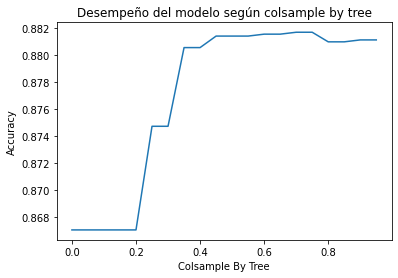

In [33]:
import matplotlib.pyplot as plt
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(new_estimator_range, accuracy_scores)
plt.xlabel('Colsample By Tree')
plt.ylabel('Accuracy')
plt.title('Desempeño del modelo según colsample by tree')

In [34]:
# Definición del modelo con los parámetros learning rate = 0.05, gamma = 0.35 y colsample_bytree = .65
xgb_best = XGBClassifier(learning_rate=.05, random_state=1, n_jobs=-1, gamma =.35, colsample_bytree = .65 )
xgb_best.fit(X, y)
xgb_best_accuracy = cross_val_score(xgb_best, X, y, cv=5, scoring='accuracy').mean()
print("\n\nMejor modelo calibrado - Parametros Accuracy: " , xgb_best_accuracy)



Mejor modelo calibrado - Parametros Accuracy:  0.8828013339685563


Con respecto a la calibración de XGBoost, se puede observar que el accuracy mejora un poco, pasando de 0.87 a 0.88. El hiperparámetro que más mejora el desempeño es Gamma, sin embargo, los tres hiperparámetros calibrados presentan una similar influencia en el accuracy. El modelo calibrado es el siguiente:

* learning rate = 0.05
* gamma = 0.35
* colsample_bytree = 0.65

Como indica la teoría, XGBoost calibrado presenta un mejor desempeño de Random Forest calibrado

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

Text(0.5, 1.0, 'Comparación de modelos según accuracy')

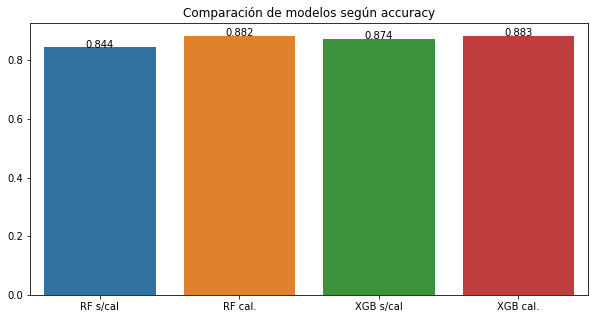

In [39]:
# Comparación de modelos:

import seaborn as sns
modelos = ['RF s/cal', 'RF cal.', 'XGB s/cal','XGB cal.']
accuracy_modelos = [round(RF_accuracy,3),round(rf_best_accuracy,3), round(xgb_accuracy,3), round(xgb_best_accuracy,3)]
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
plt.figure(figsize = (10,5))
sns.barplot(x = modelos, y = accuracy_modelos)
addlabels(modelos, accuracy_modelos)
plt.title('Comparación de modelos según accuracy')


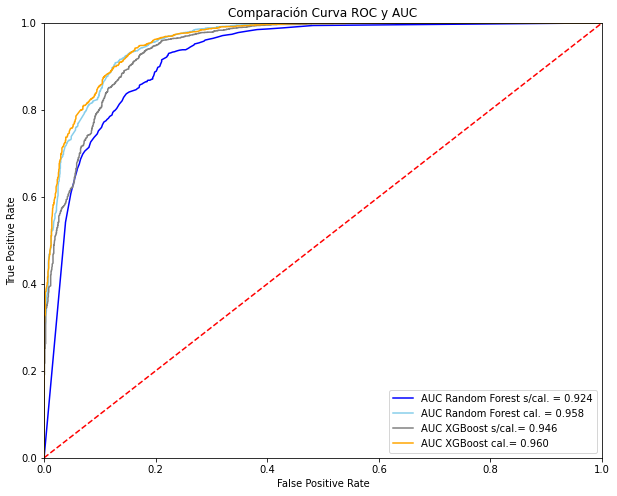

In [46]:
#### Comparación curvas ROC y AUC

import sklearn.metrics as metrics
# Random Forest sin calibrar
probs_rf = RF_clsf.predict_proba(X_test)
preds_rf = probs_rf[:,1]
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test, preds_rf)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

# Random Forest calibrado
probs_rf_best = rf_best.predict_proba(X_test)
preds_rf_best = probs_rf_best[:,1]
fpr_rf_best, tpr_rf_best, threshold_rf_best = metrics.roc_curve(y_test, preds_rf_best)
roc_auc_rf_best = metrics.auc(fpr_rf_best, tpr_rf_best)

# XGBoost sin calibrar
probs_xgb = xgb.predict_proba(X_test)
preds_xgb = probs_xgb[:,1]
fpr_xgb, tpr_xgb, threshold_xgb = metrics.roc_curve(y_test, preds_xgb)
roc_auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

# XGBoost calibrado
probs_xgb_best = xgb_best.predict_proba(X_test)
preds_xgb_best = probs_xgb_best[:,1]
fpr_xgb_best, tpr_xgb_best, threshold_xgb_best = metrics.roc_curve(y_test, preds_xgb_best)
roc_auc_xgb_best = metrics.auc(fpr_xgb_best, tpr_xgb_best)



# method I: plt
# import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.title('Comparación Curva ROC y AUC')
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC Random Forest s/cal. = %0.3f' % roc_auc_rf, color = 'blue')
plt.plot(fpr_rf_best, tpr_rf_best, 'b', label = 'AUC Random Forest cal. = %0.3f' % roc_auc_rf_best, color = 'skyblue')
plt.plot(fpr_xgb, tpr_xgb, 'b', label = 'AUC XGBoost s/cal.= %0.3f' % roc_auc_xgb, color = 'gray')
plt.plot(fpr_xgb_best, tpr_xgb_best, 'b', label = 'AUC XGBoost cal.= %0.3f' % roc_auc_xgb_best, color = 'orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




#### Conclusiones

Para realizar la evaluación de los modelos, se utilizaron las métricas Accuracy y AUC. En cuanto al accuracy, los modelos calibrados tuvieron un mejor desempeño que aquellos que no fueron calibrados. Como lo indica la teoría, XGBoost calibrado presenta un mejor accuracy que Random Forest calibrado (0.883 vs. 0.882). La diferencia es mucho mayor en los modelos no calibrados. En este grupo XGBoost sin calibrar presenta un accuracy de 0.874 vs. el accuracy de Random Forest sin calibrar (0.844). En esta comparación se puede observar que, a pesar de no estar calibrado, XGBoost presenta un mejor desempeño, sin embargo, Random Forest y XGBoost presentan un desempeño bastante similar si son calibrados correctamente.

Con respecto al AUC, el modelo XGBoost calibrado presenta un marcado mejor desempeño que todos los demas, llegando a 0.960. Al igual que con el accuracy, el modelo Random Forest calibrado ocupa el segundo lugar, con 0.958. XGBoost sin calibrar y Random Forest sin calibrar muestran AUC de 0.946 y 0.924 respectivamente. Nuevamente, XGBoost presenta un desempeño general mejor que Random Forest